# Here be dragons: exploring the stellar mass-halo mass relation in the dwarf regime with EMERGE...the notebook!
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [UPDATE](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/galtrees/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

## IMPORT LIBRARIES

In [1]:
from galaxybox import sim_managers as gb
from galaxybox.plot.plot import ls # some extra linestyle options

# Standard imports
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import subprocess
import h5py
import os
from sys import version
import glob
import yaml

# Astropy imports
from astropy import cosmology as apcos
import astropy.units as apunits
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from halotools.mock_observables import radial_distance
from astropy.convolution import convolve
from astropy.convolution.kernels import Gaussian1DKernel
from astropy.convolution.kernels import Gaussian2DKernel

# Scipy imports
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.stats import kde

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import seaborn as sns

from IPython.display import display, Math


### package versions

In [66]:
# export my conda environment config to yml file.
with open(os.path.abspath('code-configs/environment.yml'), 'w') as fp:
    subprocess.call(['conda', 'env', 'export'], stdout=fp)

In [57]:
# I'm using galaxybox in dev mode. Print the current git-hash and system to build.yml

encoding='utf-8'
path = '/home/joleary/Programs/galaxybox'

with open('code-configs/build.yml', 'r') as stream:
    build = yaml.safe_load(stream)

args = ['git', 'describe', '--dirty', '--always', '--tags']
process = subprocess.Popen(args, stdout=subprocess.PIPE, cwd=path)
build['Code']['Galaxybox']['git-hash'] = process.stdout.read().decode(encoding).strip()
args = ['hostname']
process = subprocess.Popen(args, stdout=subprocess.PIPE, cwd=path)
build['Code']['Galaxybox']['system'] = process.stdout.read().decode(encoding).strip()

with open('code-configs/build.yml', 'w') as stream:
    yaml.dump(build, stream)

## PLOTTING DEFAULTS

In [4]:
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm',
                     'figure.facecolor' : 'white'})

## IMPORT DATA

In [36]:
DATA_DIR = '/scratch/users/joleary/dwarves'
P60 = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale.param'), sim_type = 'emerge')
P60_inst = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale_inst.param'), sim_type = 'emerge')
P60_linmax = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale_linmax.param'), sim_type = 'emerge')
P60_logistic = gb.Universe(param_path = os.path.join(DATA_DIR, 'parameterfiles/Royale_logistic.param'), sim_type = 'emerge')

models = [P60, P60_inst, P60_linmax, P60_logistic]
for m in models:
    m.params.update('OutputDir', value=DATA_DIR)
    m.add_galaxy_catalog()
    # trees are big, so just do limited import to get some star formation history
    m.add_galaxy_trees(fields_out=['ID', 'Scale', 'Desc_ID', 'MMP_ID', 'Leaf_ID', 'Stellar_mass', 'Halo_mass', 'SFR', 'Scale_peak_mass', 'Mean_age', 'Type'])
    m.galaxy_trees.sort_index()
    m.add_statistics()
    m.add_fits()
    m.add_figdir(os.path.abspath('./Figures/'))

Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale/statistics.h5
Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale_inst/statistics.h5
Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale_linmax/statistics.h5
Loading galaxy lists:


Loading galaxy trees:   0%|          | 0/64 [00:00<?, ?it/s]

Loading statistics:
/scratch/users/joleary/dwarves/Royale_logistic/statistics.h5


In [19]:
# Load local group data
LG = pd.read_csv('./local_group.dat',index_col=0, skipinitialspace=True, na_values='-')

# Section 4: Results

## Section 4.1: Model Selection

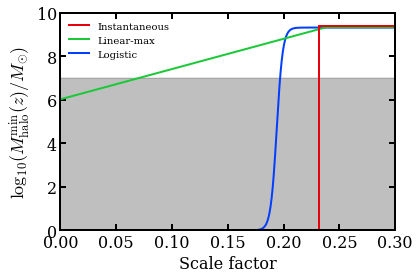

In [50]:
# define each quenching model
def logistic(x, x0=0.5, k=-1, L=1):
    return L / (1+np.exp(-(10**(k))*(x-x0)))
def linear(x, m=1, b=1):
    return m*x + b
def linear_max(x,m=1,ymax=1,xmax=1):
    m = 10**m
    x = np.atleast_1d(x)
    y = m*(x-xmax)+ymax
    mask = (y >= ymax)
    y[mask] = ymax
    return y


x = np.linspace(0,1,1000)
miny, maxy = 0, 10
minx, maxx = 0, 0.3
fig, ax = plt.subplots()
ax.set_ylim([miny,maxy])
ax.set_xlim([minx,maxx])
ax.set_xlabel('Scale factor', size= 16)
ax.set_ylabel('$\log_{10}(M^{\mathrm{min}}_{\mathrm{halo}}(z)/M_{\odot})$', size=18)

# plot logistic model
xm, y, k = P60_logistic.params.get_param('Reionization_Scale'), P60_logistic.params.get_param('Reionization_Mass'), P60_logistic.params.get_param('Reionization_Rate')
ax.plot(x,logistic(x, x0=xm, k=k, L=y), color=sns.color_palette('bright')[0], lw=2)

# plot lin-max model
xm, y, k = P60_linmax.params.get_param('Reionization_Scale'), P60_linmax.params.get_param('Reionization_Mass'), P60_linmax.params.get_param('Reionization_Rate')
ax.plot(x,linear_max(x, m=k, ymax=y, xmax=xm), ls='-', color=sns.color_palette('bright')[2], lw=2)

# plot instantaneous model
xm, y = P60_inst.params.get_param('Reionization_Scale'), P60_inst.params.get_param('Reionization_Mass')
ax.axvline(x=xm, ymin=0, ymax=(y-miny)/(maxy-miny), color=sns.color_palette('bright')[3], lw=2)
ax.axhline(y=y, xmin=xm/(maxx-minx), xmax=1, color=sns.color_palette('bright')[3], lw=2)

# plot resolution limit
ax.fill_between(x,np.zeros(len(x))+7, np.zeros(len(x)), alpha=0.25, color='k')

handles = [Line2D([0], [0], color=sns.color_palette('bright')[3], lw=2, ls='-', label='Instantaneous')]
handles += [Line2D([0], [0], color=sns.color_palette('bright')[2], lw=2, ls='-', label='Linear-max')]
handles += [Line2D([0], [0], color=sns.color_palette('bright')[0], lw=2, ls='-', label='Logistic')]
ax.legend(handles=handles, frameon=False)

#P60.savefig('mod_compare.pdf')
plt.show()

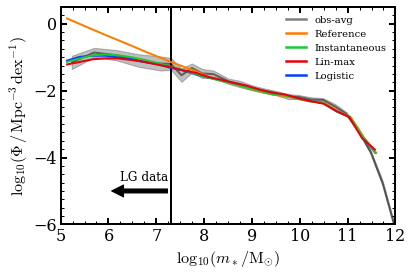

In [56]:
smf = np.loadtxt('./smf.dat', skiprows=1, delimiter=',')

fig,ax = plt.subplots()
ax.set_xlabel('$\log_{10}(m_* / \mathrm{M}_{\odot})$', size=16)
ax.set_ylabel('$\log_{10}(\Phi \, / \, \mathrm{Mpc}^{-3}\,\mathrm{dex}^{-1})$', size=16)
ax.set_xlim([5,12])
ax.set_ylim([-6,0.5])
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(5,13,1)))
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,13,0.25)))
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-6,1,0.25)))

model_label = [ 'Logistic', 'Reference', 'Instantaneous', 'Lin-max']
model_color = sns.color_palette('bright')
models = [P60_logistic, P60, P60_inst, P60_linmax]

# plot smf for each model
for i, m in enumerate(models):
    galaxies = m.galaxy.list(min_mstar=5)
    Lbox = m.params.get_param('BoxSize') / m.cosmology.h
    vol = (Lbox**3)

    N, edges = np.histogram(galaxies['Stellar_mass'].values, bins=25)
    centers = (edges[:-1] + edges[1:]) / 2
    db = (edges[1] - edges[0])
    
    ax.plot(centers, np.log10(N / db / vol), color=model_color[i], lw=2, label=model_label[i],zorder=10)

# plot observed data   
ax.plot(smf[:,0],smf[:,1], label='obs-avg', lw = 2, color = 'black', alpha=0.5)
ax.fill_between(smf[:,0], smf[:,2], smf[:,3], color='black', alpha=0.25,zorder=0)

# set legend
color = sns.color_palette('bright')
handles = [Line2D([0], [0], color='k', lw=2.5, alpha=0.5, label='obs-avg'),
           Line2D([0], [0], color=model_color[1], lw=2.5, label='Reference'),
           Line2D([0], [0], color=model_color[2], lw=2.5, label='Instantaneous'),
           Line2D([0], [0], color=model_color[3], lw=2.5, label='Lin-max'),
           Line2D([0], [0], color=model_color[0], lw=2.5, label='Logistic')]
ax.legend(handles = handles, frameon=False)

# annotations to shown range of local group data
ax.axvline(x=7.3, ymin=-7, ymax=1, color='black', lw=2)
ax.annotate('', xy=(6, -5),  xycoords='data',
            xytext=(7.3, -5), textcoords='data',
            arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            )
ax.annotate('LG data', xy=(7.25, -4.8), xycoords='data', size=12, ha='right', va='bottom')
#P60.savefig('global_smf.pdf', bbox_inches='tight')
plt.show()

## Section 4.2: Stellar-to-Halo mass relation

### SHMR

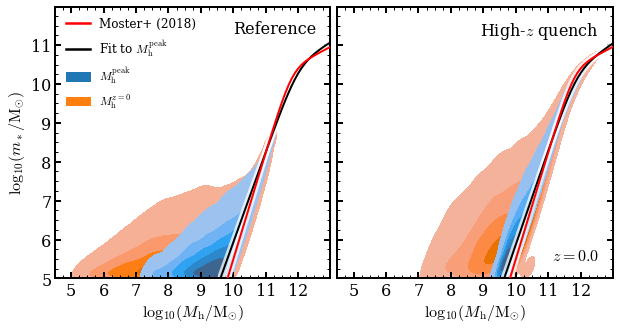

In [47]:
def log_efficiency(M, M1, eps_N, beta, gamma):
    return np.log10(2*eps_N)-np.log10((10**(M-M1))**(-beta) + (10**(M-M1))**gamma)

def double_power(x, a, b, c, d):
    return x+b-np.log10((10.**(x-a))**(-c)+(10.**(x-a))**(d))

# setup the data
vmin, vmax = -12.5, -8.9 
mh_min, mh_max, bin_size = 10, 13.7, 0.2
mbin=np.arange(mh_min,mh_max,bin_size)
redshift=0
#galaxies = model.galaxy.list(z=redshift, min_mstar=5) # select only type 0 galaxies
f_baryon = P60.cosmology.Ob0 / P60.cosmology.Om0

mbin=np.arange(mh_min,mh_max,bin_size)

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([5,11.99])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('$\log_{10}(m_*/\mathrm{M}_{\odot})$',size = 16)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[0].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(4,15))
ax[0].set_xlim([4.5,12.99])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([4.5,12.99])

# Reference model
glist = P60.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[0], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[0], levels=6, fill=True, zorder=0)
# fit double power law
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
# plot
ax[0].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[0].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)
ax[0].annotate('Reference', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')

# logistic
glist = P60_logistic.galaxy.list(z=redshift, min_mstar=5)
sns.kdeplot(data=glist, x='Halo_mass_peak', y="Stellar_mass", ax=ax[1], levels=6, fill=True)
sns.kdeplot(data=glist, x='Halo_mass', y="Stellar_mass", ax=ax[1], levels=6, fill=True,zorder=0)
# fit double power law
mhalo,_,_ = binned_statistic(glist['Halo_mass_peak'], glist['Halo_mass_peak'], statistic='mean',bins=mbin)
mstar,_,_= binned_statistic(glist['Halo_mass_peak'], glist['Stellar_mass'], statistic='mean',bins=mbin)
popt, pcov = curve_fit(double_power, mhalo, mstar,p0=[10,1,1,1],maxfev=10000)
# plot
ax[1].plot(x,double_power(x,*popt),color='black',lw=2,zorder=10)
ax[1].plot(x,double_power(x,*popt),color='white',lw=7,alpha=0.75)
ax[1].annotate('High-$z$ quench', xy=(1-0.05, 1-0.05), xycoords='axes fraction', size=16, ha='right', va='top',color='k')

# moster 2018
x = np.arange(9,15,0.1)
old = np.array([11.80, 0.14, 1.75, 0.57]) # parameters from moster 2018
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[0].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='r',lw=2,zorder=10, label='Moster+ (2018)')
ax[1].plot(x,np.log10((10**log_efficiency(x,*old))*(f_baryon*10**x)),color='white',lw=7,alpha=0.75)

ax[1].annotate('$z={:.1f}$'.format(redshift), xy=(1-0.05, 0.05), xycoords='axes fraction', size=16, ha='right', va='bottom')

handles = [Line2D([0], [0], color='r', lw=2.5, ls='-', label='Moster+ (2018)'),
           Line2D([0], [0], color='k', lw=2.5, ls='-', label='Fit to $M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[0], label='$M^{\mathrm{peak}}_{\mathrm{h}}$'),
           patches.Patch(color=sns.color_palette()[1], label='$M^{z=0}_{\mathrm{h}}$') ]
ax[0].legend(handles=handles, frameon=False, fontsize=12)
#P60.savefig('SHMR_split.pdf', bbox_inches='tight')

### Scatter in SHMR

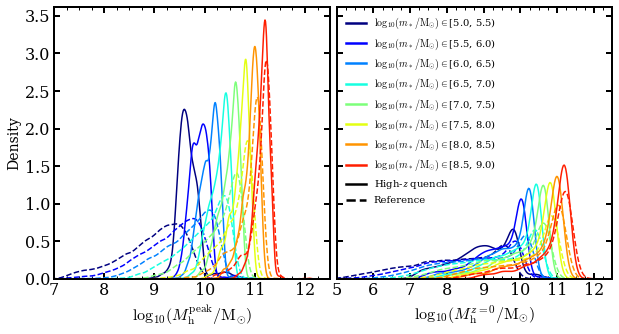

In [49]:
from scipy.stats import kde
def color(n, tot):
    return plt.cm.jet(n / tot, 1)

mbin = np.arange(5,9.5,0.5)
percentile=68 

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.025)
#ax[0].set_ylim([5,11.99])
#ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(5, 13, 0.25)))
#ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.arange(5, 13, 1)))
ax[0].set_ylabel('Density', size = 14)
ax[0].set_xlabel('$\log_{10}(M^{\mathrm{peak}}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)
ax[1].set_xlabel('$\log_{10}(M^{z=0}_{\mathrm{h}}/\mathrm{M}_{\odot})$',size=16)

#for i, axi in enumerate(ax.reshape(-1)):
ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(7, 14.5+1, 0.25)))
ax[0].xaxis.set_ticks(np.arange(7,15))
ax[0].set_xlim([7,12.49])

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.arange(4, 14.5+1, 0.25)))
ax[1].xaxis.set_ticks(np.arange(4,15))
ax[1].set_xlim([5,12.49])

handles = []
models = [P60, P60_logistic]
ls = ['--', '-']
md = ['_peak', '']
for i in range(len(mbin)-1):
    txt = '$\in [{:.1f}, {:.1f})$ '.format(mbin[i], mbin[i+1])
    
    for j, m in enumerate(models):
        glist = m.galaxy.list(z=redshift, min_mstar=mbin[i], max_mstar=mbin[i+1])
        N = len(glist)
        of = (glist.Type==2).sum()/N
        txt += '& ${:d}$ & ${:.2f}$ '.format(N, of)
        for d, axi in enumerate(ax.reshape(-1)):
            sns.kdeplot(glist['Halo_mass'+md[d]].values, color=color(i, len(mbin)-1), ax=ax[d], ls=ls[j])

            k = kde.gaussian_kde(glist['Halo_mass'+md[d]].values)
            x = np.linspace(4,12,1000)
            y = k.evaluate(x)
            #peak, _ = find_peaks(y, height=0.5*y.max())
            peak = np.argmax(y)
            n=0
            mask = y > y[peak]*(0.95-n*0.01)
            while k.integrate_box_1d(x[mask][0], x[mask][-1]) < 0.68:
                n+=1
                mask = y > y[peak]*(0.98-n*0.01)

            q  = np.abs(x[mask][[0,-1]] - x[peak])

            s = '& ${0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}$ '
            txt += s.format(x[peak], q[0], q[1])

    label = '$\log_{10}(m_*/\mathrm{M}_{\odot}) \in$' + '[{:.1f}, {:.1f})'.format(mbin[i], mbin[i+1])
    handles += [Line2D([0], [0], color=color(i, len(mbin)-1), lw=2.5, ls='-', label=label)]
    txt += '\\\\'
    #print(txt)

handles += [Line2D([0], [0], color='k', lw=2.5, ls='-', label='High-$z$ quench'),
            Line2D([0], [0], color='k', lw=2.5, ls='--', label='Reference')]
ax[1].legend(handles=handles, frameon=False)
#P60.savefig('SHMR_scatter_joint.pdf', bbox_inches='tight')

## Section 4.3: Satellite populations

### sat smf

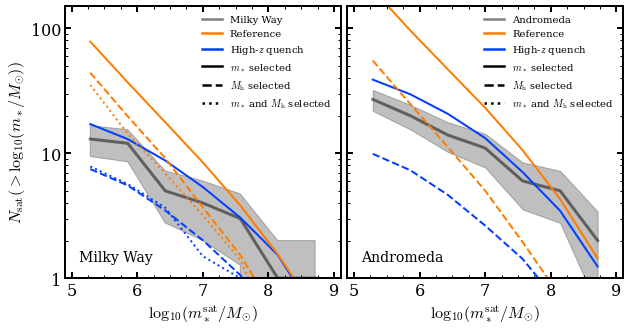

In [39]:
MW_sats = LG.loc[LG.D_MW < 300]
M31_sats = LG.loc[LG.D_M31 < 300]

model_label = ['High-$z$ quench', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_yscale('log')
ax[0].set_ylim([1,150])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax[0].set_ylabel('$N_{\mathrm{sat}}(>\log_{10}(m_*/M_{\odot}))$',size=16)

# plot obsered sat smf.
bins = np.histogram_bin_edges([5,9],bins=7)
hist, edges = np.histogram(MW_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[0].plot(mid, N, lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

hist, edges = np.histogram(M31_sats['StellarMass'].values, bins=bins)
N = hist[::-1].cumsum()[::-1]
mid = (edges[1:] + edges[:-1])/2
ax[1].plot(mid, N, lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, N+np.sqrt(N), N-np.sqrt(N), color='black', alpha=0.25)

# cases are the stellar/halo mass ranges used for the MW and M31 respectively
cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\log_{10}(m_*^{\mathrm{sat}}/M_{\odot})$', size=16)
    axi.set_xlim([4.9,9.1])
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,10,0.25)))

    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case): 
            min_mstar, max_mstar, min_mvir, max_mvir = c
            # find all hosts that fit criteria
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            Ntot = np.zeros(len(edges)-1)
            # loop over hosts
            for index, row in hosts.iterrows():
                # collect all satellites of that host and add to the hist.
                sats = m.galaxy.list(ihost=index, min_mstar=5)
                hist, _ = np.histogram(sats['Stellar_mass'].values, bins=bins)
                N = hist[::-1].cumsum()[::-1]

                Ntot += N
            axi.plot(mid, Ntot/len(hosts), lw=2, color=model_color[j], ls=ls[k])

# first legend 
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='upper right', frameon=False)

# second legend
handles[0] = Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5)
ax[1].legend(handles=handles, loc='upper right', frameon=False)

ax[0].annotate('Milky Way', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')
ax[1].annotate('Andromeda', xy=(0.05, 0.05), xycoords='axes fraction', size=14, ha='left', va='bottom')

#P60.savefig('cumulative_sat_smf.pdf', bbox_inches='tight')
plt.show()

### sat distribution

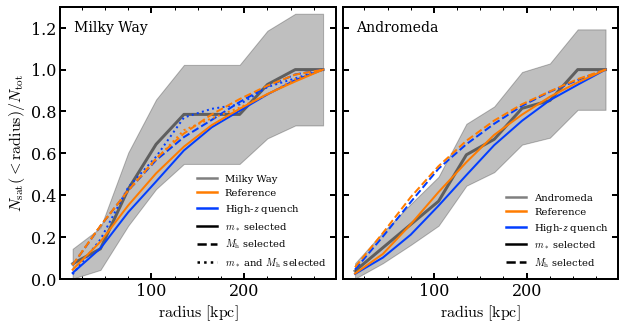

In [41]:
MW_sats = LG.loc[LG.D_MW < 300]
M31_sats = LG.loc[LG.D_M31 < 300]

model_label = ['Logistic', 'Reference']
model_color = ['blue', 'green']
model_color = sns.color_palette('bright')
ls = ['-', '--', ':']
mass_range = [(10.5, 10.8),
              (10.8, 11.2)]
models = [P60_logistic, P60]
mvir_range = [(np.log10(1e12), np.log10(2e12)),
              (np.log10(1.4e12), np.log10(5e12))]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)
ax[0].set_ylim([0,1.3])
ax[0].set_ylabel('$N_{\mathrm{sat}}(<\mathrm{radius})/N_{\\mathrm{tot}}$',size=16)

# plot obsered sat dist.
bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(MW_sats['D_MW'], bins=bins)
N = hist.cumsum()
mid = (bins[1:] + bins[:-1])/2
ax[0].plot(mid, N/N[-1], lw=3, color='black', label='Milky Way', alpha=0.5)
ax[0].fill_between(mid, (N+np.sqrt(N))/N[-1], (N-np.sqrt(N))/N[-1], color='black', alpha=0.25)

bins = np.histogram_bin_edges([0,300],bins=10)
hist, _ = np.histogram(M31_sats['D_M31'], bins=bins)
N = hist.cumsum()
ax[1].plot(mid, N/N[-1], lw=3, color='black', label='Andromeda', alpha=0.5)
ax[1].fill_between(mid, (N+np.sqrt(N))/N[-1], (N-np.sqrt(N))/N[-1], color='black', alpha=0.25)

# cases are the stellar/halo mass ranges used for the MW and M31 respectively
cases = [((10.6, 10.78, 0, np.inf),
         (5, np.inf, 12.0, 12.2),
         (10.6, 10.78, 12.0, 12.2)),
         ((10.93, 11.1, 0, np.inf),
         (5, np.inf, 12.15, 12.3),
         (10.93, 11.1, 12.15, 12.3))]

for i, axi in enumerate(ax.reshape(-1)):
    min_mstar, max_mstar = mass_range[i]
    min_mvir, max_mvir = mvir_range[i]
    axi.set_xlabel('$\mathrm{radius\,\,[kpc]}$',size=16)
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,500,25)))

    case = cases[i]
    for j, m in enumerate(models):
        for k, c in enumerate(case):
            Ntot = np.zeros(len(bins)-1)
            min_mstar, max_mstar, min_mvir, max_mvir = c
            # find all hosts that fit criteria
            hosts = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=0,z=0, min_mvir=min_mvir, max_mvir=max_mvir)
            # loop over hosts
            for index, row in hosts.iterrows():
                # collect all satellites of that host and add to the hist.
                sats = m.galaxy.list(ihost=index, min_mstar=5)
                pos = sats[['X_pos','Y_pos','Z_pos']].values
                xs, ys, zs = pos[:,0], pos[:,1], pos[:,2]

                x,y,z = row[['X_pos','Y_pos','Z_pos']].values
                xc, yc, zc = [x]*len(pos), [y]*len(pos), [z]*len(pos)
                r_sat = radial_distance(xs, ys, zs, xc, yc, zc, period=m.params.get_param('BoxSize')/m.cosmology.h)
                hist, _ = np.histogram(r_sat*1000, bins=bins)
                N = hist.cumsum()
                Ntot += N
                Nmax = Ntot[-1]/len(hosts)
            axi.plot(mid, Ntot/len(hosts)/Nmax, lw=2, color=model_color[j], ls=ls[k])

# first legend
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Milky Way', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls=':', label='$m_*$ and $M_{\\mathrm{h}}$ selected')]
ax[0].legend(handles=handles, loc='lower right', frameon=False)

# second legend
handles = [Line2D([0], [0], color='black', lw=2.5, ls='-', label='Andromeda', alpha=0.5),
           Line2D([0], [0], color=model_color[1], lw=2.5, ls='-', label='Reference'),
           Line2D([0], [0], color=model_color[0], lw=2.5, ls='-', label='High-$z$ quench'),
           Line2D([0], [0], color='black', lw=2.5, ls='-', label='$m_*$ selected'),
           Line2D([0], [0], color='black', lw=2.5, ls='--', label='$M_{\\mathrm{h}}$ selected')]
ax[1].legend(handles=handles, loc='lower right', frameon=False)

ax[0].annotate('Milky Way', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
ax[1].annotate('Andromeda', xy=(0.05, 1-0.05), xycoords='axes fraction', size=14, ha='left', va='top')
#P60.savefig('cumulative_sat_smf_normed.pdf', bbox_inches='tight')
plt.show()

## Section 4.4: Star formation history

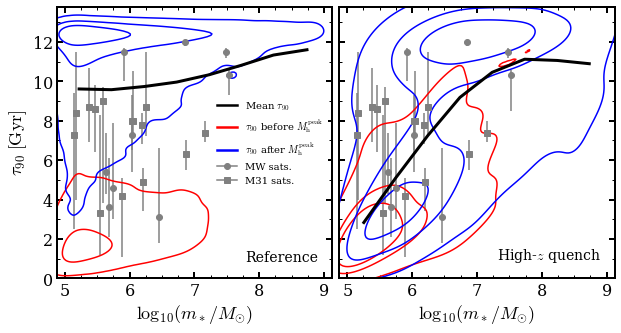

In [37]:
MW_sats = LG.loc[LG.D_MW < 300]
M31_sats = LG.loc[LG.D_M31 < 300]

mbin=np.arange(5,15,0.5)
min_mstar, max_mstar = 5, 9
stat = 'mean'
frac = 0.9
gtype = [1,2]

model_label = ['Reference', 'High-$z$ quench']
model_color = ['black', 'red', 'blue', 'green']
colors = ["#FF0B04", "#4374B3"]
colors = ["red", "blue"]

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.025)

ax[0].set_ylabel(r'$\tau_{90}\;[\mathrm{Gyr}]$', size=18)
ax[0].set_ylim([0, models[0].cosmology.age(0).value])
ax[0].yaxis.set_minor_locator(ticker.FixedLocator(np.arange(0,14,1)))

models = [P60, P60_logistic]
model_label = ['Reference', 'High-$z$ quench']
colors = ["red", "blue"]

for i, axi in enumerate(ax.reshape(-1)):
    axi.set_xlim([4.875,9.125])
    axi.set_xlabel('$\log_{10}(m_*/M_{\odot})$', size=18)
    axi.xaxis.set_major_locator(ticker.FixedLocator(np.arange(5,13,1)))
    axi.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(5,13,0.25)))
    
    axi.errorbar(MW_sats['StellarMass'].values, MW_sats['t90'].values, yerr = np.abs(MW_sats[['t90_down', 't90_up']].values.astype(float).T), ls='', marker='o', color='grey')
    axi.errorbar(M31_sats['StellarMass'].values, M31_sats['t90'].values, yerr = np.abs(M31_sats[['t90_down', 't90_up']].values.astype(float).T), ls='', marker='s', color='grey')
    axi.annotate(model_label[i], xy=(1-0.05, 0.05), xycoords='axes fraction', size=14, ha='right', va='bottom',color='k')
    
    m = models[i]
    ihost = m.galaxy.list(min_mstar=10.5, max_mstar=11.2).index.values
    igal = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=gtype, ihost=ihost).index.values
    s = m.galaxy_trees.scale_at_massfrac(igal, frac=frac, interpolate=False)
    mstar = m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar,gtype=gtype, ihost=ihost)['Stellar_mass'].values
    mgal,_,_ = binned_statistic(mstar, mstar, statistic=stat, bins=mbin)
    fr,_,_ = binned_statistic(mstar, m.cosmology.age(1/s-1), statistic=stat, bins=mbin)
    axi.plot(mgal, fr, lw=3, color='black')
    mask = s - m.galaxy.list(min_mstar=min_mstar, max_mstar=max_mstar, gtype=gtype, ihost=ihost)['Scale_peak_mass'].values > 0
    data = {'mass': mstar,
            'age': m.cosmology.age(1/s-1).value,
            'mask': mask}

    with sns.color_palette(colors):
        sns.kdeplot(data=data, x='mass', y='age', ax=axi, hue='mask', levels=4,common_norm=True,legend=False)

handles = [Line2D([0], [0], color='k', lw=2.5, ls='-', label=r'Mean $\tau_{90}$'),
           Line2D([0], [0], color='r', lw=2.5, ls='-', label=r'$\tau_{90}$ before $M_{\mathrm{h}}^{\mathrm{peak}}$'),
           Line2D([0], [0], color='b', lw=2.5, ls='-', label=r'$\tau_{90}$ after $M_{\mathrm{h}}^{\mathrm{peak}}$'),
           Line2D([0], [0], color='grey', marker='o', label='MW sats.'),
           Line2D([0], [0], color='grey', marker='s', label='M31 sats.')]
ax[0].legend(handles=handles, loc = 'center right',  edgecolor='white', facecolor='white', framealpha=1)
#P60.savefig('t90_joint.pdf', bbox_inches='tight')

# Scratch